In [1]:
import pandas as pd

columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
           'Insulin', 'BMI', 'DPF', 'Age', 'Outcome']

df = pd.read_csv('pima-indians-diabetes.csv', names=columns)
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI    DPF  \
0            6      148             72             35        0  33.6  0.627   
1            1       85             66             29        0  26.6  0.351   
2            8      183             64              0        0  23.3  0.672   
3            1       89             66             23       94  28.1  0.167   
4            0      137             40             35      168  43.1  2.288   

   Age  Outcome  
0   50        1  
1   31        0  
2   32        1  
3   21        0  
4   33        1  


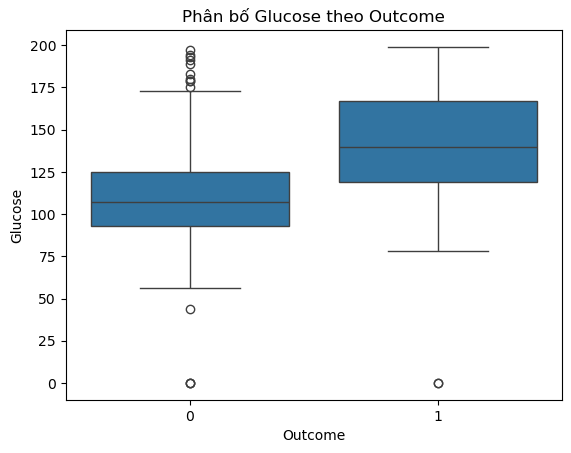

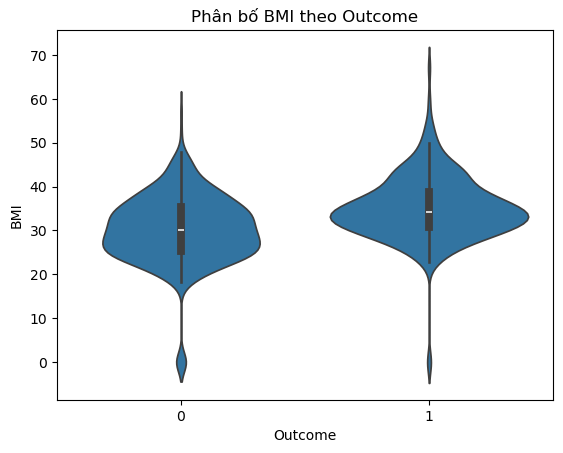

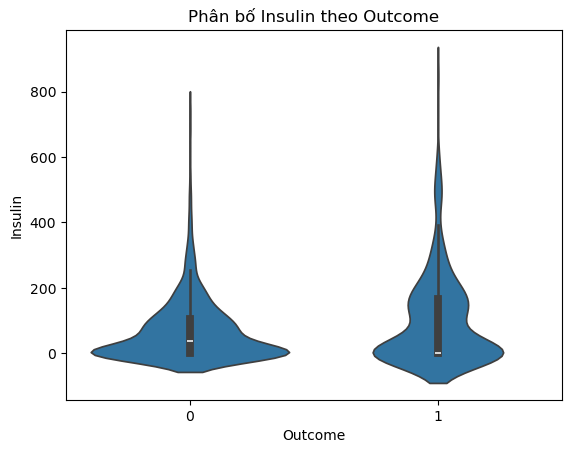

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot Glucose
sns.boxplot(x='Outcome', y='Glucose', data=df)
plt.title("Phân bố Glucose theo Outcome")
plt.show()

# Violin plot BMI
sns.violinplot(x='Outcome', y='BMI', data=df)
plt.title("Phân bố BMI theo Outcome")
plt.show()

# Violin plot Insulin
sns.violinplot(x='Outcome', y='Insulin', data=df)
plt.title("Phân bố Insulin theo Outcome")
plt.show()


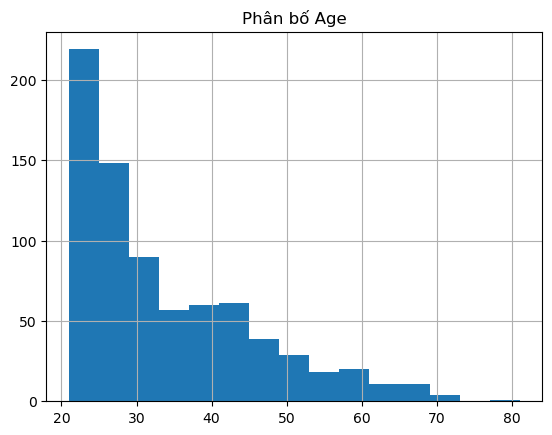

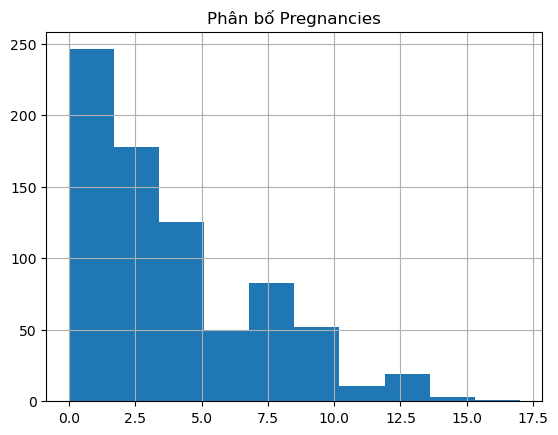

In [3]:
df['Age'].hist(bins=15)
plt.title("Phân bố Age")
plt.show()

df['Pregnancies'].hist(bins=10)
plt.title("Phân bố Pregnancies")
plt.show()


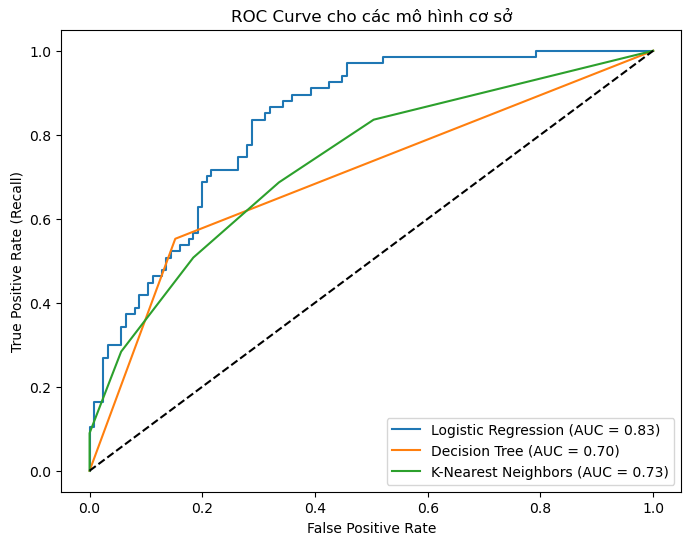

                 Model  Accuracy  Precision    Recall  F1-score       AUC
0  Logistic Regression  0.734375   0.648148  0.522388  0.578512  0.832000
1        Decision Tree  0.744792   0.660714  0.552239  0.601626  0.700119
2  K-Nearest Neighbors  0.708333   0.596491  0.507463  0.548387  0.734985


In [4]:
# Import thư viện
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# 2. Chuẩn bị dữ liệu
X = df[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DPF','Age']]
y = df['Outcome']

# 3. Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# 4. Chuẩn hóa dữ liệu (đặc biệt cho KNN & Logistic)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Khởi tạo mô hình
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# 6. Huấn luyện, dự đoán và đánh giá
results = []

plt.figure(figsize=(8,6))
for name, model in models.items():
    if name in ['Logistic Regression', 'K-Nearest Neighbors']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_prob = model.predict_proba(X_test_scaled)[:,1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:,1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    results.append([name, acc, prec, rec, f1, auc])
    
    # Vẽ ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

# ROC plot tổng hợp
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve cho các mô hình cơ sở")
plt.legend()
plt.show()

# 7. Xuất bảng kết quả
results_df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1-score','AUC'])
print(results_df)


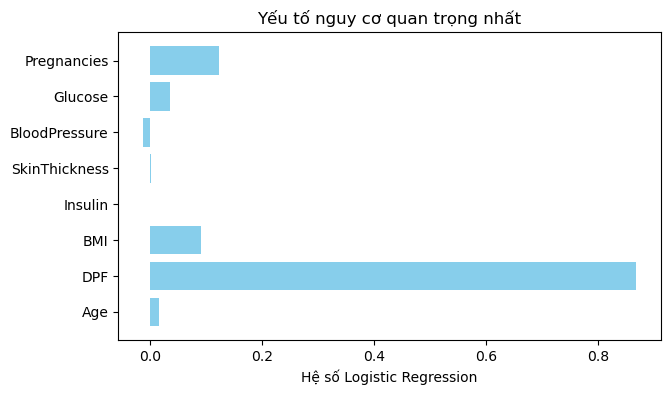

In [7]:
X = df[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DPF','Age']]
y = df['Outcome']

model = LogisticRegression(max_iter=1000)
model.fit(X, y)

coefficients = model.coef_[0]
features = X.columns

# Vẽ biểu đồ
plt.figure(figsize=(7,4))
plt.barh(features, coefficients, color='skyblue')
plt.xlabel('Hệ số Logistic Regression')
plt.title('Yếu tố nguy cơ quan trọng nhất')
plt.gca().invert_yaxis()
plt.show()

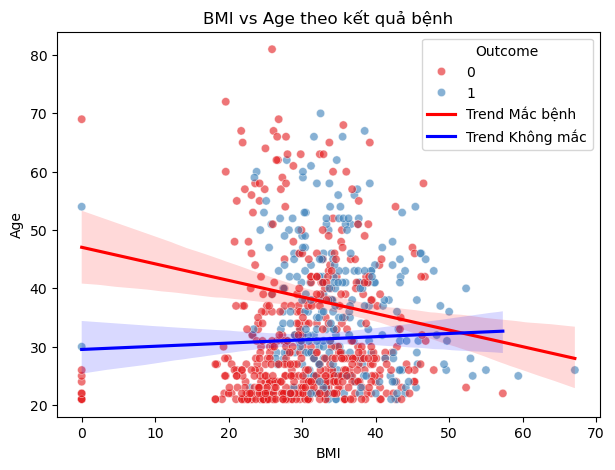

In [9]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='BMI', y='Age', hue='Outcome', palette='Set1', alpha=0.6)
sns.regplot(data=df[df['Outcome']==1], x='BMI', y='Age', scatter=False, color='red', label='Trend Mắc bệnh')
sns.regplot(data=df[df['Outcome']==0], x='BMI', y='Age', scatter=False, color='blue', label='Trend Không mắc')
plt.title('BMI vs Age theo kết quả bệnh')
plt.xlabel('BMI')
plt.ylabel('Age')
plt.legend(title='Outcome')
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_26884\3051290357.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Outcome', y='DPF', palette='Pastel1')


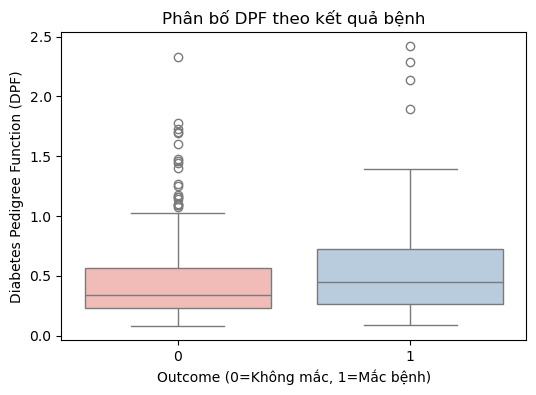

In [10]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Outcome', y='DPF', palette='Pastel1')
plt.title('Phân bố DPF theo kết quả bệnh')
plt.xlabel('Outcome (0=Không mắc, 1=Mắc bệnh)')
plt.ylabel('Diabetes Pedigree Function (DPF)')
plt.show()

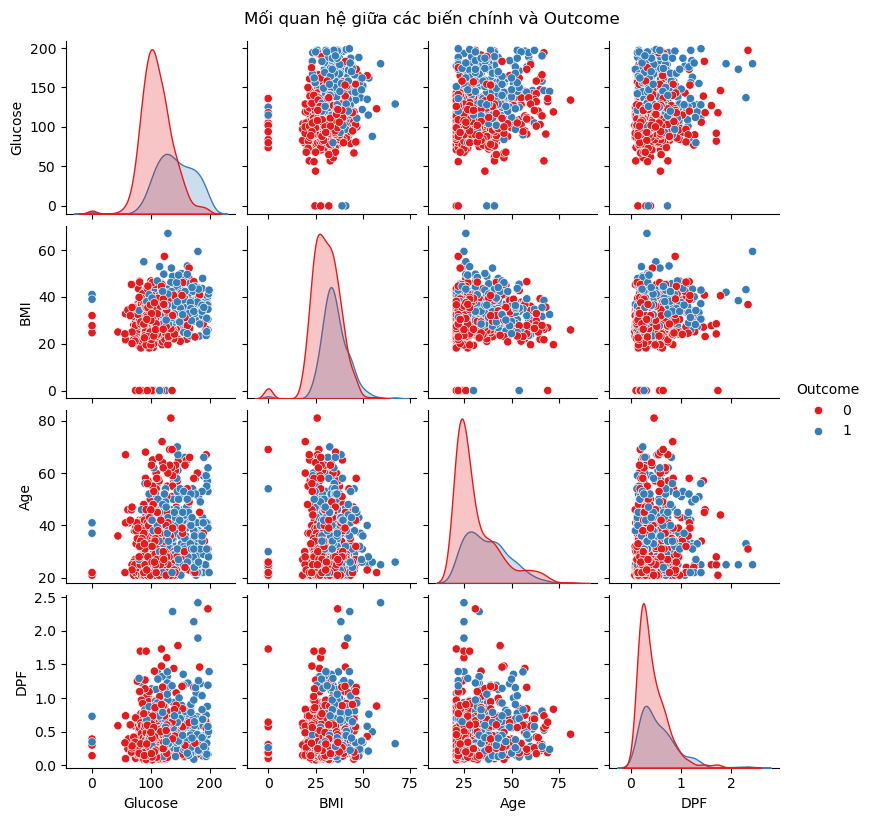

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(
    df, 
    vars=['Glucose','BMI','Age','DPF'], 
    hue='Outcome', 
    palette='Set1', 
    diag_kind='kde',
    height=2  # giảm chiều cao mỗi subplot, mặc định là 2.5–3
)
plt.suptitle('Mối quan hệ giữa các biến chính và Outcome', y=1.02)
plt.show()
